In [1]:
import numpy as np
#from random import seed, shuffle, uniform
#from math import ceil, sqrt
#from functools import reduce
from sklearn.model_selection import train_test_split

import os

# if running just for output don't halt to show plots
# plots will be saved in images folder
if __name__ != '__main__':
    print("Using no interactive")
    matplotlib.use('Agg')
    no_interact = True
else:
    no_interact = False
import matplotlib.pyplot as plt
import matplotlib.cm as cm

IMG_FOLDER = "images/"
if not os.path.exists(IMG_FOLDER):
    os.makedirs(IMG_FOLDER)

## Import DataSets

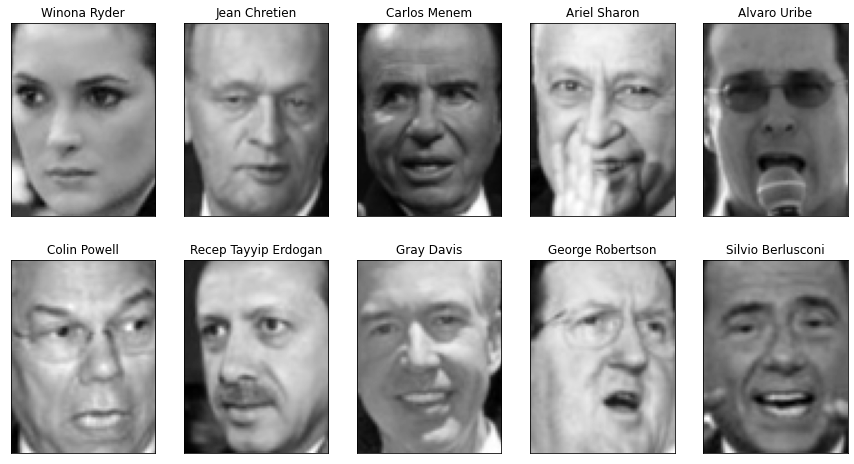

In [2]:
from sklearn.datasets import fetch_lfw_people

people = fetch_lfw_people(min_faces_per_person=20, resize=.7)
image_shape = people.images[0].shape

fig, axes = plt.subplots(2, 5, figsize=(15,8), subplot_kw={'xticks':(), 'yticks':()})

for target, image, ax in zip(people.target, people.images, axes.ravel()):
    ax.imshow(image, cmap=cm.gray)
    ax.set_title(people.target_names[target])
plt.show()


## Problem 2

In [3]:
print("people.images.shape: {}".format(people.images.shape))
print("Number of classes: {}".format(len(people.target_names)))
# count how often each target appears
counts = np.bincount(people.target)
# print counts next to target names
for i, (count, name) in enumerate(zip(counts, people.target_names)):
    print("{0:25} {1:3}".format(name, count), end="    ")
    if( (i+1) % 3 == 0 ):
        print()
mask = np.zeros(people.target.shape, dtype=np.bool)
for target in np.unique(people.target):
    mask[np.where(people.target == target)[0][:50]] = 1
    
X_people = people.data[mask]
y_people = people.target[mask]

# scale the grayscale values to be between 0 and 1
# instad of 0 and 255 for better numeric stability
X_people = X_people / 255.



people.images.shape: (3023, 87, 65)
Number of classes: 62
Alejandro Toledo           39    Alvaro Uribe               35    Amelie Mauresmo            21    
Andre Agassi               36    Angelina Jolie             20    Ariel Sharon               77    
Arnold Schwarzenegger      42    Atal Bihari Vajpayee       24    Bill Clinton               29    
Carlos Menem               21    Colin Powell              236    David Beckham              31    
Donald Rumsfeld           121    George Robertson           22    George W Bush             530    
Gerhard Schroeder         109    Gloria Macapagal Arroyo    44    Gray Davis                 26    
Guillermo Coria            30    Hamid Karzai               22    Hans Blix                  39    
Hugo Chavez                71    Igor Ivanov                20    Jack Straw                 28    
Jacques Chirac             52    Jean Chretien              55    Jennifer Aniston           21    
Jennifer Capriati          42    Jennifer 

In [4]:
print("Built in KNN")
from sklearn.neighbors import KNeighborsClassifier
# split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_people, y_people, stratify=y_people, random_state=0)
# build a KNeighborsClassifier using one neighbor
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)
print("Test set score of 1-nn: {:.2f}".format(knn.score(X_test, y_test)))

Built in KNN
Test set score of 1-nn: 0.23


In [5]:
from scipy.stats import mode

def sum_squared_diff(x1, x2):
    diff = x1-x2
    return diff.T@diff

def KNN(X_data, Y_data, test_point, k=1, similarity=sum_squared_diff):
    # not looking for super fast code here
    # therefore naive implementation of getting
    # similarities then sort and grab k smallest
    # and pick most represented class
    similarities = np.apply_along_axis(lambda x: similarity(x, test_point), axis=1, arr=X_data)
    k_nearest = Y_data[similarities.argsort()[:k]]
    # if there is a tie the smaller value is taken
    most_common = mode(k_nearest).mode[0]
    
    return most_common

In [6]:
print("My attempt at KNN")
guesses = np.apply_along_axis(lambda x: KNN(X_train, y_train, x), axis=1, arr=X_test)
print("Test set score of 1-nn {:.2f}".format(sum(guesses == y_test)/len(y_test)))


My attempt at KNN
Test set score of 1-nn 0.23


KNN on reduced data with 100dimensions
Test set score of 1-nn 0.25


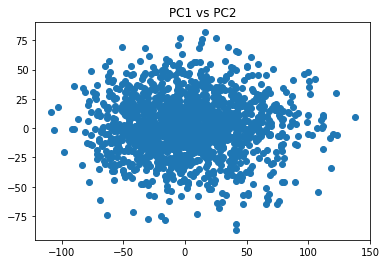

In [7]:
# normalize
x_mean  = np.mean(X_test, axis=0)
x_stdev = np.std(X_test, axis=0)
X_train_standardized = (X_train-x_mean)/x_stdev
X_test_standardized  = (X_test-x_mean)/x_stdev

def PCA_reduction(X_data, X_test):
    ## dimension should be less than the actual dimension of X_data
    #u, s, v = np.linalg.svd(X_data)
    #return X_data@vh.T[:,:dimension], X_train@vh.T[:,:dimension], (u, s, v)

    covariance = X_data.T@X_data
    e_vals, e_vecs = np.linalg.eig(covariance)
    # sort by decending, largest first
    # grab the largest
    order = e_vals.argsort()[::-1]
    e_vals = e_vals[order]
    e_vecs = e_vecs[:, order]
    # remove negative eigenvalues
    clip = e_vals > 0
    index = np.count_nonzero(clip)
    e_vals = e_vals[:index]
    e_vecs = e_vecs[:,:index]
    return X_data@e_vecs, X_test@e_vecs , e_vals, e_vecs 
    
X_train_pca, X_test_pca, e_vals, e_vecs = PCA_reduction(X_train_standardized, X_test_standardized)
X_train_100d = X_train_pca[:, :100]
X_test_100d  = X_test_pca[:, :100]

print("KNN on reduced data with 100dimensions")
guesses = np.apply_along_axis(lambda x: KNN(X_train_100d, y_train, x), axis=1, arr=X_test_100d)
print("Test set score of 1-nn {:.2f}".format(sum(guesses == y_test)/len(y_test)))
plt.title("PC1 vs PC2")
plt.scatter(X_train_pca[:,0], X_train_pca[:,1])
plt.savefig(IMG_FOLDER + "Q2-PC1-vs-PC2.png")
if(not no_interact):
    plt.show()

In [8]:
def PCA_whitening(X_data, X_test, e_vals, e_vecs):
    a = np.diag(1/np.sqrt(e_vals))
    b = e_vecs.T
    return (a@b@X_data.T).T, (a@b@X_test.T).T
X_train_whiten, X_test_whiten = PCA_whitening(X_train, X_test, e_vals, e_vecs)
X_train_whiten_100d = X_train_whiten[:,:100]
X_test_whiten_100d =  X_test_whiten[:,:100]

KNN on reduced data with 100dimensions and whitening
Test set score of 1-nn 0.30


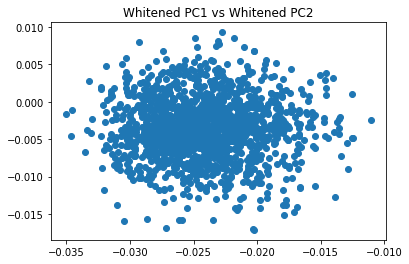

In [9]:
print("KNN on reduced data with 100dimensions and whitening")
guesses = np.apply_along_axis(lambda x: KNN(X_train_whiten_100d, y_train, x), axis=1, arr=X_test_whiten_100d)
print("Test set score of 1-nn {:.2f}".format(sum(guesses == y_test)/len(y_test)))
plt.title("Whitened PC1 vs Whitened PC2")
plt.scatter(X_train_whiten_100d[:,0], X_train_whiten_100d[:,1])
plt.savefig(IMG_FOLDER + "Q2-PC1-vs-PC2-Whitened.png")
if(not no_interact):
    plt.show()

## Problem 3

/home/dp834/.local/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


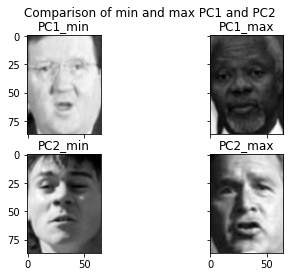

In [10]:
PC1 = X_train_pca[:,0].argsort()
PC1_max = X_train[PC1[-1]]
PC1_min = X_train[PC1[0]]
PC2 = X_train_pca[:,1].argsort()
PC2_max = X_train[PC2[-1]]
PC2_min = X_train[PC2[0]]
fig, axs = plt.subplots(2,2)
fig.suptitle("Comparison of min and max PC1 and PC2")
axs[0,0].imshow(PC1_min.reshape(87,65), cmap="gray")
axs[0,0].set_title("PC1_min")
axs[0,1].imshow(PC1_max.reshape(87,65), cmap="gray")
axs[0,1].set_title("PC1_max")
axs[1,0].imshow(PC2_min.reshape(87,65), cmap="gray")
axs[1,0].set_title("PC2_min")
axs[1,1].imshow(PC2_max.reshape(87,65), cmap="gray")
axs[1,1].set_title("PC2_max")

for ax in axs.flat:
    ax.label_outer()
fig.show()
fig.savefig(IMG_FOLDER + "Q3-PC1-PC2-min-max.png")
if(not no_interact):
    plt.show()


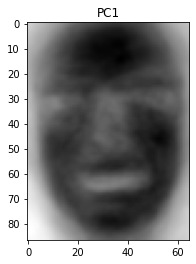

In [11]:
plt.title("PC1")
plt.imshow(e_vecs[:,0].reshape(87,65), cmap="gray")
plt.savefig(IMG_FOLDER + "Q3-PC1.png")
if(not no_interact):
    plt.show()

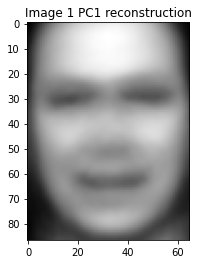

In [12]:
def PCA_reconstruction(X_data, e_vecs, mean, stdev, num_of_features):
    e_vecs = e_vecs[:,:num_of_features]
    return stdev*(np.dot(X_data[:,:num_of_features], e_vecs.T)) + mean

reconstructed_first = PCA_reconstruction(X_train_pca, e_vecs, x_mean, x_stdev, 1)
plt.title("Image 1 PC1 reconstruction")
plt.imshow(reconstructed_first[0,:].reshape(87,65), cmap="gray")
plt.savefig(IMG_FOLDER + "Q3-PC1-reconstruction.png")
if(not no_interact):
    plt.show()


Using 188 principle components for 95% reconstruction


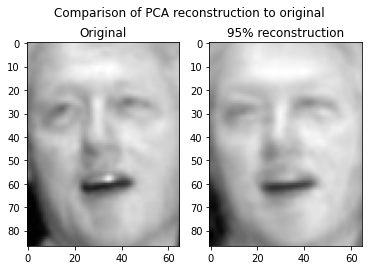

In [13]:
total = np.sum(e_vals)
partial_sum = 0
for i, e_val in enumerate(e_vals):
    partial_sum += e_val
    if(partial_sum/total >= .95):
        break

print("Using {} principle components for 95% reconstruction".format(i)) 
reconstructed_first = PCA_reconstruction(X_train_pca, e_vecs, x_mean, x_stdev, i+1)
fig, axs = plt.subplots(1,2)
fig.suptitle("Comparison of PCA reconstruction to original")
axs[0].imshow(X_train[0,:].reshape(87,65), cmap="gray")
axs[0].set_title("Original")
axs[1].imshow(reconstructed_first[0,:].reshape(87,65), cmap="gray")
axs[1].set_title("95% reconstruction")
fig.savefig(IMG_FOLDER + "Q3-image-95-reconstruction.png")
if(not no_interact):
    plt.show()